# Сборный проект — 2

Мы работаем в компании «Работа с заботой» и наша задача — помочь бизнесу сократить отток сотрудников и избежать финансовых потерь через аналитику и предсказание. Первая наша цель — разработать модель, которая предсказывает уровень удовлетворённости сотрудников на основе предоставленных данных. Это важно, потому что удовлетворённость тесно связана с оттоком. Вторая задача — предсказать вероятность увольнения сотрудников. Обе задачи помогают бизнесу своевременно реагировать на потенциальные риски, связанные с внезапными уходами ключевых специалистов.

# Используемые библиотеки

In [1]:
!pip install -Uq scikit-learn
!pip install matplotlib==3.5.0 -q
!pip install phik

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.svm import SVC

from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [3]:
#Функция для вычисления метрики SMAPE (симметричное среднее абсолютное процентное отклонение)
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))

In [4]:
# Проверим информацию о каждом DataFrame (пропущенные значения, типы данных, уникальные значения)
def check_data(df, name):
    print(f"Информация о {name}:")
    df.info()
    print(f"Пропущенные значения в {name}:")
    display(df.isnull().sum())
    print(f"Дубликаты в {name}: {df.duplicated().sum()}")

In [5]:
# Уникальные значения в датафрейме
def display_unique_values(df, df_name):
    print(f"Уникальные значения в таблице {df_name}:")
    for col in df.select_dtypes(include='object').columns:
        unique_values = df[col].unique()
        print(f"Столбец '{col}': {unique_values}")

# Задача 1: предсказание уровня удовлетворённости сотрудника

## Загрузка данных

In [6]:
train_features = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

display(train_features.head())

display(test_features.head())

display(test_target.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Наблюдения: целевой признак job_satisfaction_rate присутсвует в тренировочной выборке, вынесем его

In [7]:
merged_train = train_features

train_target = train_features['job_satisfaction_rate']

train_features = train_features.drop(['job_satisfaction_rate'], axis=1)
train_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,155278,sales,junior,medium,2,no,no,1,24000
1,653870,hr,junior,high,2,no,no,5,38400
2,184592,sales,junior,low,1,no,no,2,12000
3,171431,technology,junior,low,4,no,no,2,18000
4,693419,hr,junior,medium,1,no,no,3,22800


In [8]:
train_target

0       0.58
1       0.76
2       0.11
3       0.37
4       0.20
        ... 
3995    0.45
3996    0.68
3997    0.76
3998    0.48
3999    0.18
Name: job_satisfaction_rate, Length: 4000, dtype: float64

In [9]:
merged_test_features = pd.merge(test_features, test_target, on='id', how='inner')

test_target = merged_test_features['job_satisfaction_rate']

test_features = merged_test_features.drop(['job_satisfaction_rate'], axis=1)

test_target

0       0.79
1       0.72
2       0.64
3       0.60
4       0.75
        ... 
1995    0.56
1996    0.14
1997    0.11
1998    0.43
1999    0.67
Name: job_satisfaction_rate, Length: 2000, dtype: float64

Разбили данные, получили будущие X_test, X_train, y_test, y_train.

## Предобработка данных

In [10]:
check_data(train_features, 'test_features')

Информация о test_features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   3994 non-null   object
 2   level                  3996 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 281.4+ KB
Пропущенные значения в test_features:


id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Дубликаты в test_features: 0


In [11]:
check_data(test_features, 'test_features')

Информация о test_features:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.2+ KB
Пропущенные значения в test_features:


id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Дубликаты в test_features: 0


In [12]:
test_target.describe()

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

In [13]:
train_target.describe()

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

In [14]:
display_unique_values(train_features, 'train_features')

Уникальные значения в таблице train_features:
Столбец 'dept': ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Столбец 'level': ['junior' 'middle' 'sinior' nan]
Столбец 'workload': ['medium' 'high' 'low']
Столбец 'last_year_promo': ['no' 'yes']
Столбец 'last_year_violations': ['no' 'yes']


In [15]:
display_unique_values(test_features, 'test_features')

Уникальные значения в таблице test_features:
Столбец 'dept': ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Столбец 'level': ['junior' 'middle' 'sinior' nan]
Столбец 'workload': ['medium' 'low' 'high' ' ']
Столбец 'last_year_promo': ['no' 'yes']
Столбец 'last_year_violations': ['no' 'yes']


In [16]:
test_features[(test_features == ' ').any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


In [17]:
test_features.replace(' ', np.nan, inplace=True)
display_unique_values(test_features, 'test_features')

Уникальные значения в таблице test_features:
Столбец 'dept': ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Столбец 'level': ['junior' 'middle' 'sinior' nan]
Столбец 'workload': ['medium' 'low' 'high' nan]
Столбец 'last_year_promo': ['no' 'yes']
Столбец 'last_year_violations': ['no' 'yes']


Наблюдения: 
- обнаружены пропущенные значения в датафреймах train_features и test_features, а конкретно в столбцах dept и level. Так как пропуски занимают очень малую часть, заполним их модой, заполним их в пайплайне в будущем.
- Также были обнаружены пробелы вместо значений в столбцах workload и dept, они были заменены на NaN и также будут заполнены в пайплайне
- дубликатов не обнаружено
- несостыковок по типу данных не обнаружено

## Исследовательский анализ данных

In [18]:
discrete_columns = ['employment_years', 'supervisor_evaluation']
quantitative_columns = ['salary']
categorical_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
target_columns = ['job_satisfaction_rate']

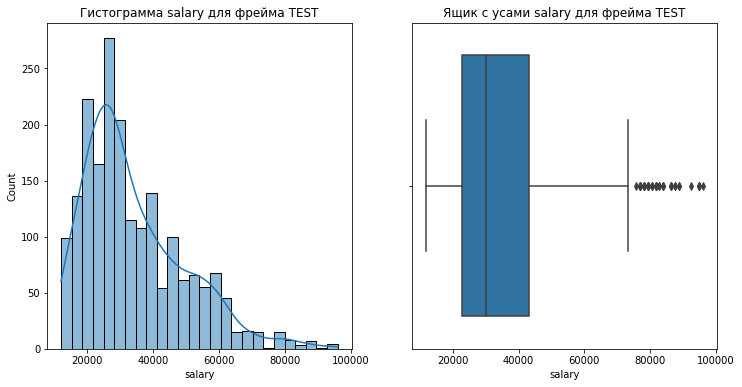

In [19]:
for column in quantitative_columns:
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(test_features[column], kde=True)
    plt.title(f'Гистограмма {column} для фрейма TEST')
    
    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=test_features[column])
    plt.title(f'Ящик с усами {column} для фрейма TEST')
    
    plt.show()

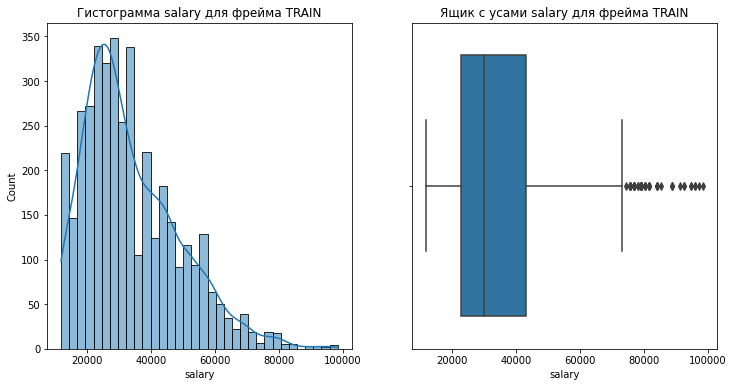

In [20]:
for column in quantitative_columns:
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(train_features[column], kde=True)
    plt.title(f'Гистограмма {column} для фрейма TRAIN')
    
    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_features[column])
    plt.title(f'Ящик с усами {column} для фрейма TRAIN')
    
    plt.show()

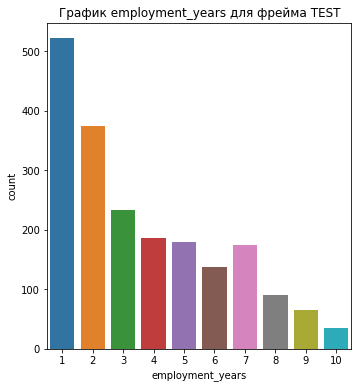

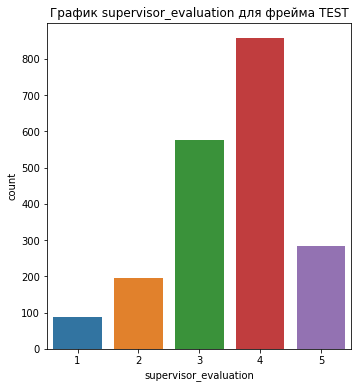

In [21]:
for column in discrete_columns:
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.countplot(x=column, data=test_features)
    plt.title(f'График {column} для фрейма TEST')
    plt.show()

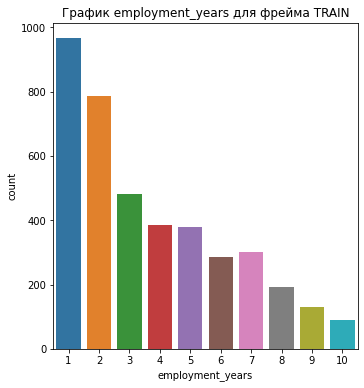

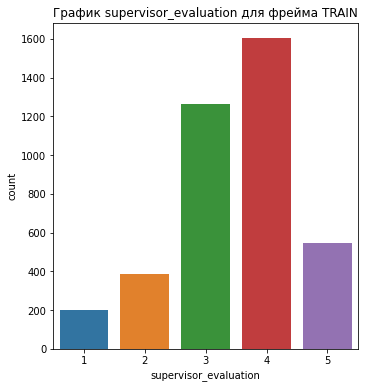

In [22]:
for column in discrete_columns:
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.countplot(x=column, data=train_features)
    plt.title(f'График {column} для фрейма TRAIN')
    plt.show()

- Чаще всего руководители дают своим сотрудникам оценки 4 и 3.

- Большинство сотрудников работает от 1 до 2 лет в компании

- Средняя зарплата сотрудников - 31000

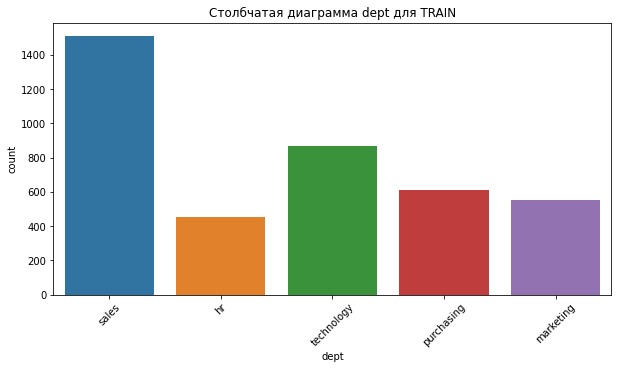

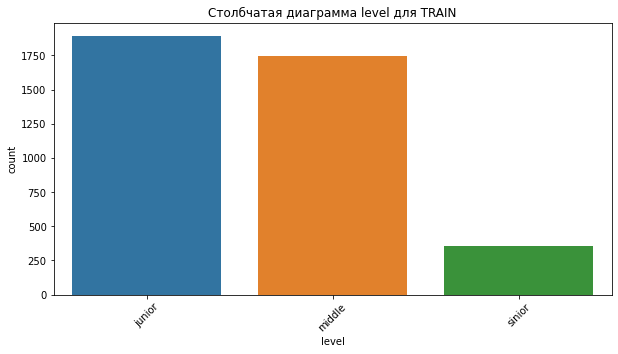

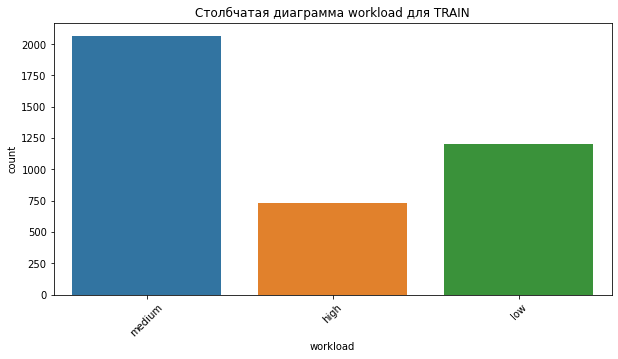

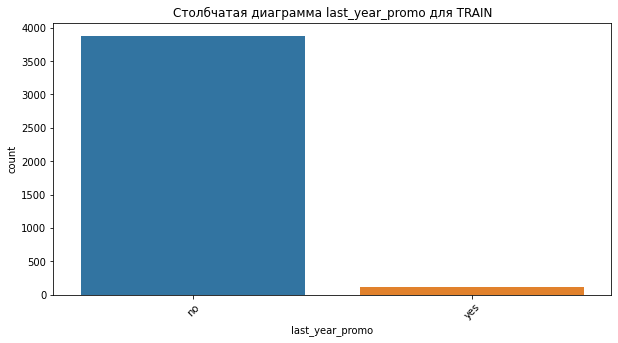

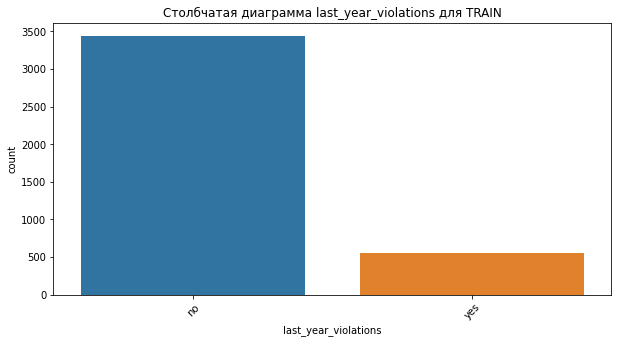

In [23]:
for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    
    # Столбчатая диаграмма
    sns.countplot(data=train_features, x=column)
    plt.title(f'Столбчатая диаграмма {column} для TRAIN')
    plt.xticks(rotation=45)
    
    plt.show()

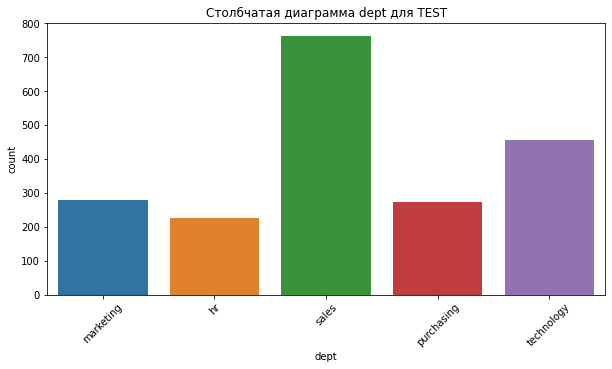

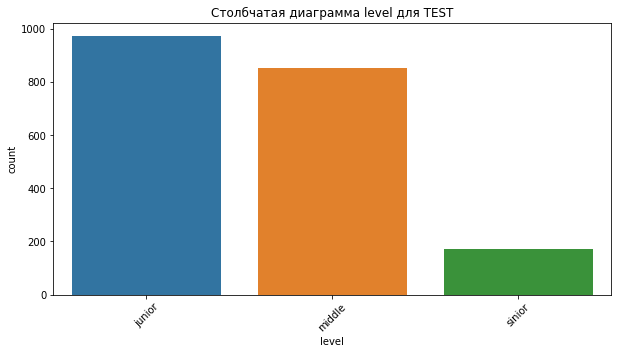

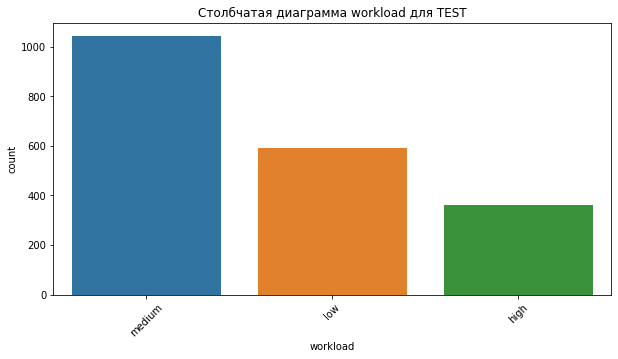

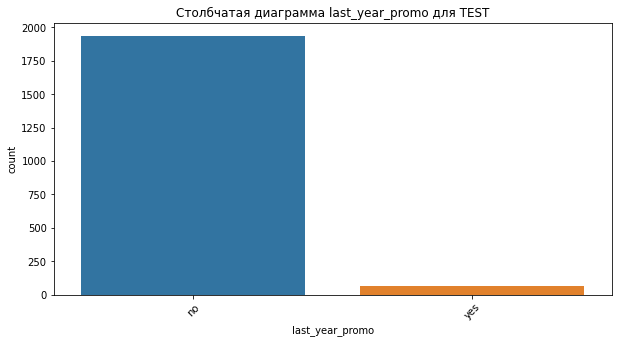

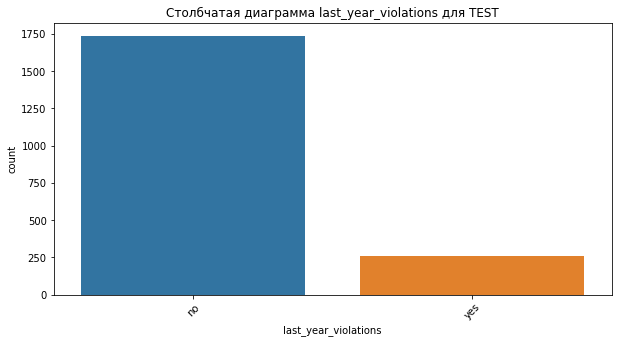

In [24]:
for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    
    # Столбчатая диаграмма
    sns.countplot(data=test_features, x=column)
    plt.title(f'Столбчатая диаграмма {column} для TEST')
    plt.xticks(rotation=45)
    
    plt.show()

- Больше всего сотрудников работает в отделе продаж, меньше всего в HR

- Младшие и средние сотрудники занимаю львиную долю от всех сотрудников

- У примерно 50 процентов сотрудников средняя загруженность, у 30 процентов низкая и у 20 процентов высокая

- Почти у всех сотрудников не было повышения за последний год.

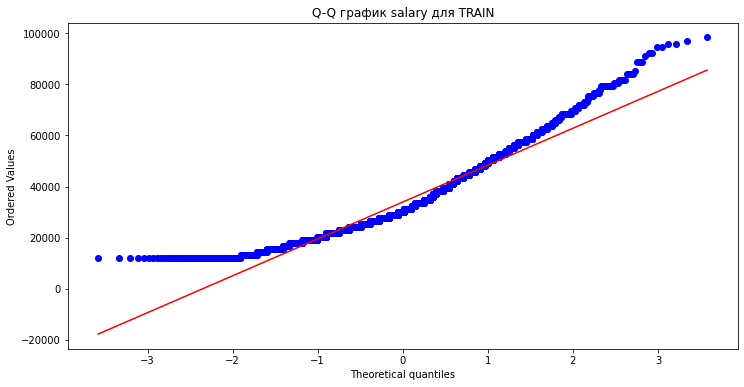

Тест Шапиро-Уилка для salary для TRAIN: p-value = 8.396205410765251e-38


In [25]:
for column in quantitative_columns:
    plt.figure(figsize=(12, 6))
    
    # Q-Q график
    stats.probplot(train_features[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q график {column} для TRAIN')
    
    plt.show()
    
    # Тест Шапиро-Уилка
    stat, p_value = stats.shapiro(train_features[column].dropna())
    print(f'Тест Шапиро-Уилка для {column} для TRAIN: p-value = {p_value}')

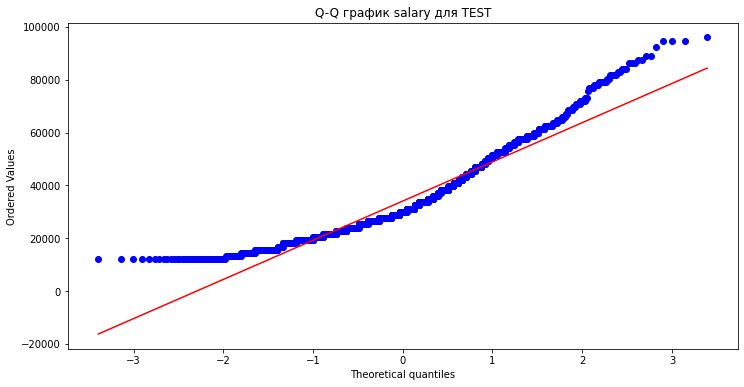

Тест Шапиро-Уилка для salary для TEST: p-value = 2.1315788254421244e-30


In [26]:
for column in quantitative_columns:
    plt.figure(figsize=(12, 6))
    
    # Q-Q график
    stats.probplot(test_features[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q график {column} для TEST')
    
    plt.show()
    
    # Тест Шапиро-Уилка
    stat, p_value = stats.shapiro(test_features[column].dropna())
    print(f'Тест Шапиро-Уилка для {column} для TEST: p-value = {p_value}')

Вывод:
- для категориальных признаков таких как dept, last_year_promo, last_year_violations будем использовать OneHotEncoder с параметром drop='first'
- для порядковых признаков таких как level, workload, supervisor_evaluation будем использовать OrdinalEncoder.
- количественные признаки employment_years, salary требуют нормализации посредством MinMaxScaler и StandardScaler.
- целевой принак job_satisfaction_rate вмешательства не требует, данне расположены от 0 до 1
- тестовый и тренировочный датафреймы имеют одинаковое распределение признаков

In [27]:
data=merged_train.set_index('id')

In [28]:
interval_cols = ['salary', 'job_satisfaction_rate']
phik_overview = phik_matrix(data,interval_cols=interval_cols)

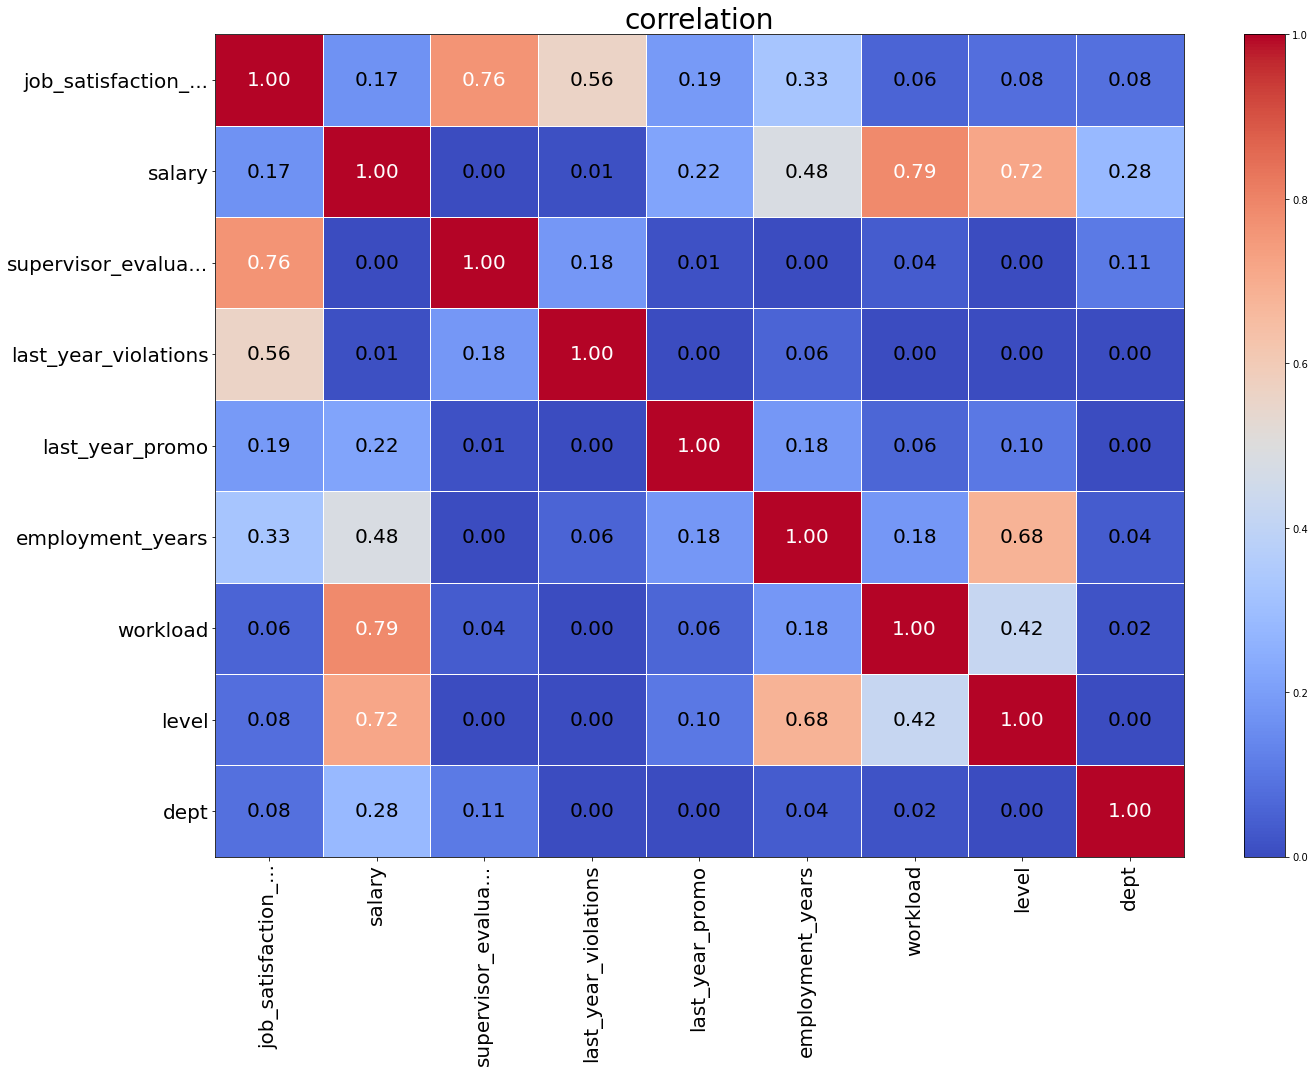

In [29]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    fontsize_factor=2,
    figsize=(20, 15)
)

Вывод: утечки целевого признака не наблюдается

## Подготовка данных

In [30]:
ohe_columns = [
    'dept', 'last_year_promo', 'last_year_violations'
]

ord_columns = [
    'level', 'workload'
]

num_columns = [
    'employment_years', 'salary'
]

In [31]:
num_pipe = Pipeline(
    [
    ('simpleImputer_num', SimpleImputer(strategy='median')),
    ('scaler_standard', StandardScaler()),  
    ('scaler_minmax', MinMaxScaler())   
    ]
)

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

# SimpleImputer + ORD + SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_columns),
        ('ord', ord_pipe, ord_columns),
        ('ohe', ohe_pipe, ohe_columns)
    ],
    remainder='passthrough'
)

## Обучение моделей

In [32]:
# Создание метрики SMAPE
smape_scorer = make_scorer(score_func=smape, greater_is_better=False)

In [33]:
X_train = train_features.drop(['id'], axis=1)
X_test = test_features.drop(['id'], axis=1)

y_train = train_target
y_test = test_target

In [34]:
RANDOM_STATE = 42

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    
    # Словарь для модели DecisionTreeClassifier
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),  
        'models__max_features': range(2, 15),    
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Словарь для модели ElasticNet
    {
        'models': [ElasticNet(random_state=RANDOM_STATE)],
        'models__alpha': [0.1, 0.5, 1.0],           
        'models__l1_ratio': [0.1, 0.5, 0.7, 1.0],     
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [35]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    scoring=smape_scorer, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('simpleImputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler_standard',
                                                                                          StandardScaler()),
                                                                                         ('scaler_minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['employment_years',
                                                                          'salary']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleI...
                          'models__max_features': range(2, 15),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [ElasticNet(random_state=42)],
                          'models__alpha': [0.1, 0.5, 1.0],
                          'models__l1_ratio': [0.1, 0.5, 0.7, 1.0],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [36]:
result1 = pd.DataFrame(grid_search.cv_results_)

pd.set_option('display.max_colwidth', None)

result1[
    ['rank_test_score', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,mean_test_score,params
463,1,-15.050629,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 13, 'preprocessor__num': MinMaxScaler()}"
460,1,-15.050629,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 12, 'preprocessor__num': MinMaxScaler()}"
457,1,-15.050629,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 11, 'preprocessor__num': MinMaxScaler()}"
466,1,-15.050629,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 14, 'preprocessor__num': MinMaxScaler()}"
465,5,-15.069760,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 14, 'preprocessor__num': StandardScaler()}"
...,...,...,...
529,532,-39.963243,"{'models': ElasticNet(random_state=42), 'models__alpha': 0.5, 'models__l1_ratio': 1.0, 'preprocessor__num': MinMaxScaler()}"
528,532,-39.963243,"{'models': ElasticNet(random_state=42), 'models__alpha': 0.5, 'models__l1_ratio': 1.0, 'preprocessor__num': StandardScaler()}"
526,532,-39.963243,"{'models': ElasticNet(random_state=42), 'models__alpha': 0.5, 'models__l1_ratio': 0.7, 'preprocessor__num': MinMaxScaler()}"
534,532,-39.963243,"{'models': ElasticNet(random_state=42), 'models__alpha': 1.0, 'models__l1_ratio': 0.5, 'preprocessor__num': StandardScaler()}"


In [37]:
best_model = grid_search.best_estimator_

print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_*-1)
print(f'Метрика sMAPE лучшей модели на тестовой выборке: {smape(y_test, best_model.predict(X_test))}')

Метрика лучшей модели на тренировочной выборке: 15.050629491396611
Метрика sMAPE лучшей модели на тестовой выборке: 14.44874240196051


Вывод: лучше справилась модель DesicionTreeRegressor c параметрами max_depth=13, max_features=13, random_state=42, потому что:

- DecisionTreeRegressor способен учитывать нелинейные зависимости между входными и выходными данными, что делает его более универсальным инструментом по сравнению с линейными моделями

- В процессе построения дерева решений DecisionTreeRegressor автоматически определяет важность каждого признака и использует только наиболее значимые из них. Это помогает избежать переобучения модели

- DecisionTreeRegressor не предполагает какого-либо конкретного распределения данных, в отличие от некоторых других методов машинного обучения

# Задача 2: предсказание увольнения сотрудника из компании

## Загрузка данных

In [38]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [39]:
test_features = pd.read_csv('/datasets/test_features.csv')
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [40]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [41]:
merged_train = train_quit

train_target = merged_train['quit']

train_features = merged_train.drop(['quit'], axis=1)
train_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,723290,sales,middle,high,2,no,no,4,54000
1,814010,sales,junior,medium,2,no,no,4,27600
2,155091,purchasing,middle,medium,5,no,no,1,37200
3,257132,sales,junior,medium,2,no,yes,3,24000
4,910140,marketing,junior,medium,2,no,no,5,25200


In [42]:
train_target

0        no
1        no
2        no
3       yes
4        no
       ... 
3995     no
3996     no
3997    yes
3998     no
3999    yes
Name: quit, Length: 4000, dtype: object

In [43]:
merged_test = pd.merge(test_features, test_target_quit, on='id', how='inner')

test_target = merged_test['quit']

test_features = merged_test.drop(['quit'], axis=1)

test_target

0        no
1        no
2        no
3        no
4        no
       ... 
1995    yes
1996    yes
1997    yes
1998     no
1999     no
Name: quit, Length: 2000, dtype: object

Разбили данные, получили будущие X_test, X_train, y_test, y_train.

## Предобработка данных

In [44]:
check_data(train_features, 'train_features')

Информация о train_features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 281.4+ KB
Пропущенные значения в train_features:


id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Дубликаты в train_features: 0


In [45]:
train_target.describe()

count     4000
unique       2
top         no
freq      2872
Name: quit, dtype: object

In [46]:
check_data(test_features, 'test_features')

Информация о test_features:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.2+ KB
Пропущенные значения в test_features:


id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Дубликаты в test_features: 0


In [47]:
test_target.describe()

count     2000
unique       2
top         no
freq      1436
Name: quit, dtype: object

In [48]:
display_unique_values(train_features, 'train_features')

Уникальные значения в таблице train_features:
Столбец 'dept': ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Столбец 'level': ['middle' 'junior' 'sinior']
Столбец 'workload': ['high' 'medium' 'low']
Столбец 'last_year_promo': ['no' 'yes']
Столбец 'last_year_violations': ['no' 'yes']


In [49]:
display_unique_values(test_features, 'test_features')

Уникальные значения в таблице test_features:
Столбец 'dept': ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Столбец 'level': ['junior' 'middle' 'sinior' nan]
Столбец 'workload': ['medium' 'low' 'high' ' ']
Столбец 'last_year_promo': ['no' 'yes']
Столбец 'last_year_violations': ['no' 'yes']


Обнаружеы пробелы в столбцах dept, workload. Заменим их на nan.

In [50]:
test_features.replace(' ', np.nan, inplace=True)
display_unique_values(test_features, 'test_features')

Уникальные значения в таблице test_features:
Столбец 'dept': ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Столбец 'level': ['junior' 'middle' 'sinior' nan]
Столбец 'workload': ['medium' 'low' 'high' nan]
Столбец 'last_year_promo': ['no' 'yes']
Столбец 'last_year_violations': ['no' 'yes']


Наблюдения:

- обнаружены пропущенные значения в датафреймах train_features и test_features, а конкретно в столбцах dept и level. Так как пропуски занимают очень малую часть, заполним их модой, заполним их в пайплайне в будущем.

- Также были обнаружены пробелы вместо значений в столбцах workload и dept, они были заменены на NaN и также будут заполнены в пайплайне

- дубликатов не обнаружено

- несостыковок по типу данных не обнаружено

## Исследовательский анализ данных

In [51]:
merged_features = pd.concat([train_features, test_features])

In [52]:
discrete_columns = ['employment_years', 'supervisor_evaluation']

quantitative_columns = ['salary']

categorical_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

target_columns = ['quit']

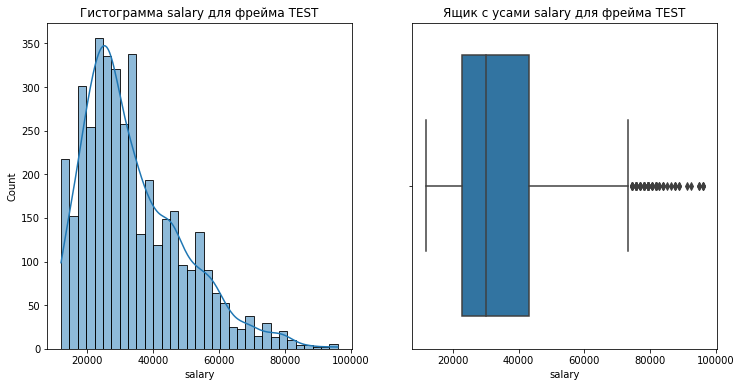

In [53]:
for column in quantitative_columns:
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(train_features[column], kde=True)
    plt.title(f'Гистограмма {column} для фрейма TEST')
    
    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_features[column])
    plt.title(f'Ящик с усами {column} для фрейма TEST')
    
    plt.show()

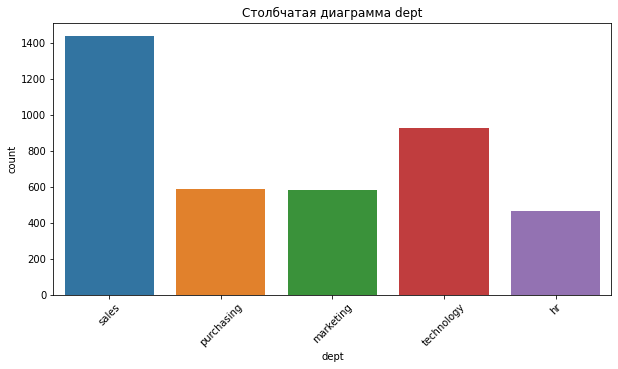

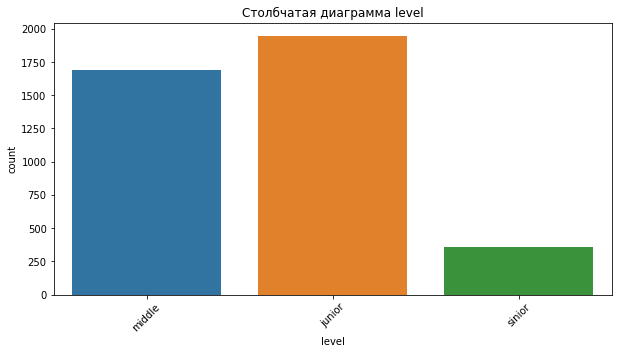

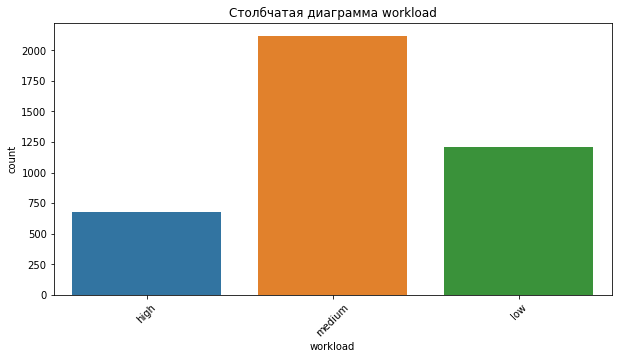

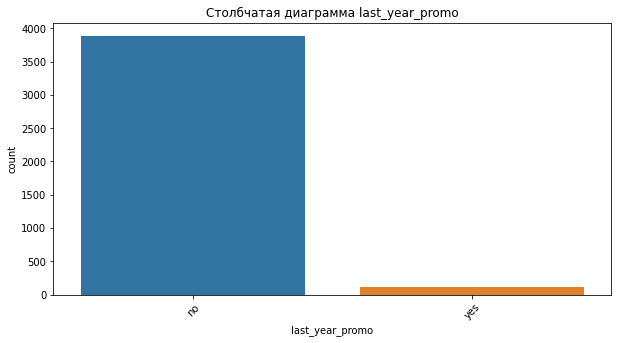

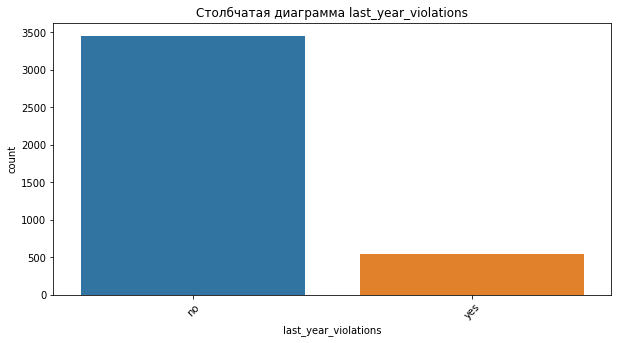

In [54]:
for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    
    # Столбчатая диаграмма
    sns.countplot(data=train_features, x=column)
    plt.title(f'Столбчатая диаграмма {column}')
    plt.xticks(rotation=45)
    
    plt.show()

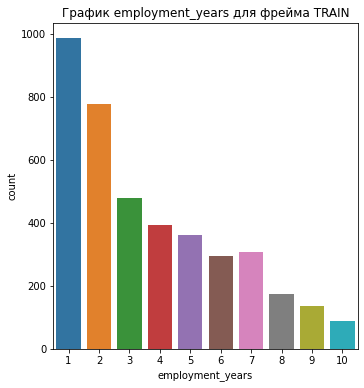

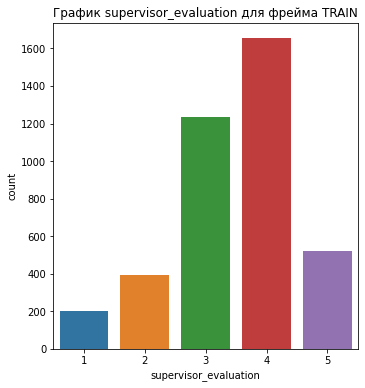

In [55]:
for column in discrete_columns:
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.countplot(x=column, data=train_features)
    plt.title(f'График {column} для фрейма TRAIN')
    plt.show()

Вывод: данные тренировочного и тестового датафреймов (тестовый на обе задачи один и тот же) имеют похожее распределение данных.

In [56]:
merged_full_df = pd.concat([merged_test, merged_train])

In [57]:
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral']

Text(0.5, 1.0, 'Процент уволившихся сотрудников по отделу')

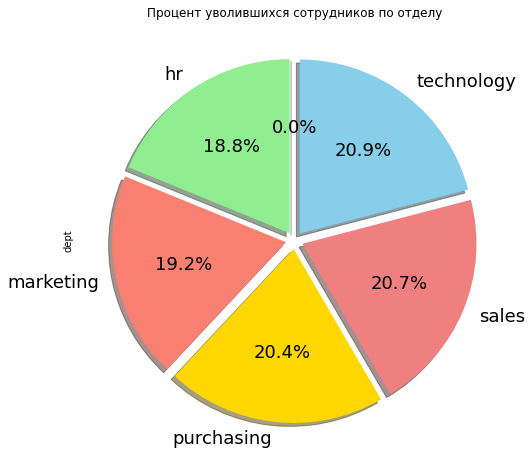

In [58]:
dept_total = merged_full_df['dept'].value_counts()

dept_quit = merged_full_df[merged_full_df['quit'] == 'yes']['dept'].value_counts()

dept_quit_ratio = (dept_quit / dept_total) * 100

dept_quit_ratio.plot(kind='pie', 
                         autopct='%1.1f%%',  # отображение процентов
                         colors=colors,  # цвета секторов
                         startangle=90,  # начальный угол для разворота диаграммы
                         explode=[0.05] * len(dept_quit_ratio),  # выделение каждого сектора
                         shadow=True,
                        figsize=(10, 8),
                        fontsize=18)  # добавление тени для эффекта объема

plt.title('Процент уволившихся сотрудников по отделу')

Наибольший процент увольнений среди сотрудников происходит в отделе технологий, но и другие отделы не отстают. Возможно клиент провел сокращения, либо работников не устраивает рабочее место

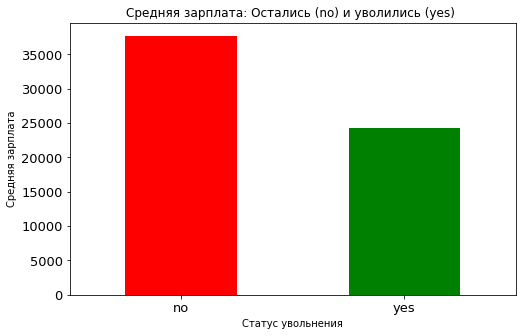

Text(0.5, 1.0, 'Процент уволившихся сотрудников по уровню загруженности')

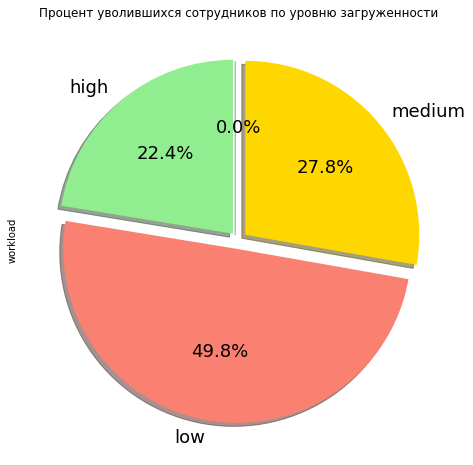

In [59]:
workload_total = merged_full_df['workload'].value_counts()

workload_quit = merged_full_df[merged_full_df['quit'] == 'yes']['workload'].value_counts()

workload_quit_ratio = (workload_quit / workload_total) * 100

average_salary = merged_full_df.groupby('quit')['salary'].mean()

average_salary.plot(kind='bar', color=['red', 'green'], figsize=(8, 5), fontsize=13)
plt.title('Средняя зарплата: Остались (no) и уволились (yes) ')
plt.xlabel('Статус увольнения')
plt.ylabel('Средняя зарплата')
plt.xticks(rotation=0)
plt.show()

workload_quit_ratio.plot(kind='pie', 
                         autopct='%1.1f%%',  # отображение процентов
                         colors=colors,  # цвета секторов
                         startangle=90,  # начальный угол для разворота диаграммы
                         explode=[0.05] * len(workload_quit_ratio),  # выделение каждого сектора
                         shadow=True,
                        figsize=(10, 8),
                        fontsize=18)  # добавление тени для эффекта объема

plt.title('Процент уволившихся сотрудников по уровню загруженности')

50 процентов уволившихся сотрудников имели низкую рабочую загруженность. В купе со средней зарплатой ниже, чем у неуволившихся, это может говорить о том, что сотрудники не видели своего дальнейшего развития в компании, не было банально работы.

In [60]:
satisfaction_rate_quit = pd.merge(merged_test_features, merged_test, on='id', how='inner')

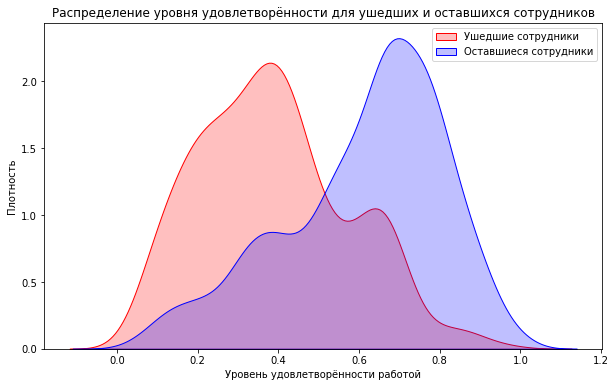

In [61]:
left = satisfaction_rate_quit[satisfaction_rate_quit['quit'] == 'yes']
stayed = satisfaction_rate_quit[satisfaction_rate_quit['quit'] == 'no']

plt.figure(figsize=(10,6))
sns.kdeplot(left['job_satisfaction_rate'], label='Ушедшие сотрудники', shade=True, color='r')
sns.kdeplot(stayed['job_satisfaction_rate'], label='Оставшиеся сотрудники', shade=True, color='b')

# Настройка графика
plt.title('Распределение уровня удовлетворённости для ушедших и оставшихся сотрудников')
plt.xlabel('Уровень удовлетворённости работой')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Аналитики правы, уровень удовлетворённости работой у уволившихся ниже, чем у оставшихся. В срднем у оставшихся уровень равен 0.7, тогда как у уволившихся 0.35.

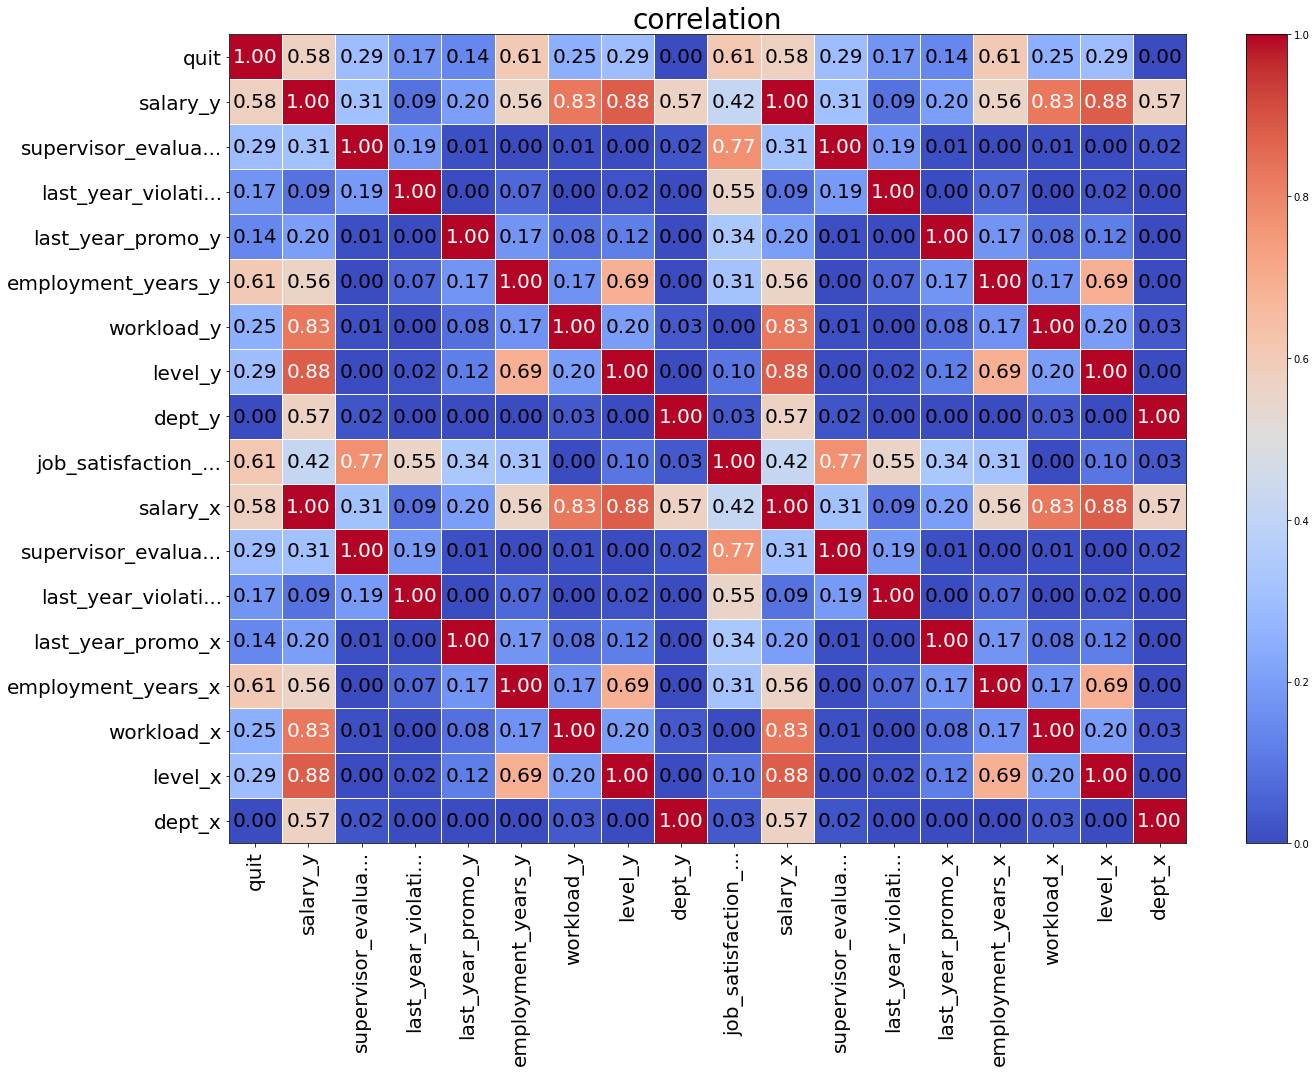

In [62]:
data2 = satisfaction_rate_quit.set_index('id')

interval_cols = ['salary', 'job_satisfaction_rate']
phik_overview2 = phik_matrix(data2, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview2.values,
    x_labels=phik_overview2.columns,
    y_labels=phik_overview2.index,
    vmin=0, vmax=1, color_map='coolwarm',
    fontsize_factor=2,
    figsize=(20, 15)
)

## Добавление нового входного признака

In [63]:
train_features['job_satisfaction_rate_pred'] = grid_search.best_estimator_.predict(train_features.drop(['id'], axis=1))

test_features['job_satisfaction_rate_pred'] = grid_search.best_estimator_.predict(X_test)

train_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,0.635385
1,814010,sales,junior,medium,2,no,no,4,27600,0.815938
2,155091,purchasing,middle,medium,5,no,no,1,37200,0.364091
3,257132,sales,junior,medium,2,no,yes,3,24000,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,0.690000


Были добавлены предказания модели из первой задачи к входным признакам.

## Подготовка данных

In [64]:
ohe_columns = [
    'dept', 'last_year_promo', 'last_year_violations'
]

ord_columns = [
    'level', 'workload'
]

num_columns = [
    'employment_years', 'salary', 'job_satisfaction_rate_pred'
]

In [65]:
num_pipe = Pipeline(
    [
    ('simpleImputer_num', SimpleImputer(strategy='median')),
    ('scaler_standard', StandardScaler()),  
    ('scaler_minmax', MinMaxScaler())   
    ]
)

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

# SimpleImputer + ORD + SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_columns),
        ('ord', ord_pipe, ord_columns),
        ('ohe', ohe_pipe, ohe_columns)
    ],
    remainder='passthrough'
)

In [66]:
X_train = train_features.drop(['id'], axis=1)
X_test = test_features.drop(['id'], axis=1)

label_encoder = LabelEncoder()

y_train2 = train_target
y_test2 = test_target

label_encoder = LabelEncoder()

y_train2 = label_encoder.fit_transform(y_train2)
y_test2 = label_encoder.transform(y_test2)

## Обучение модели

In [67]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Пайплайн для моделей
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)],
        'models__degree': range(2, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [68]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train2)

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('simpleImputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler_standard',
                                                                                          StandardScaler()),
                                                                                         ('scaler_minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['employment_years',
                                                                          'salary',
                                                                          'job_satisfaction_rate_pred']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simp...
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 6),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(kernel='poly', probability=True,
                                         random_state=42)],
                          'models__degree': range(2, 4),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [69]:
print('Метрика roc_auc для лучшей модели на тестовом датасете:\n', grid_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', grid_search.best_estimator_) 

Метрика roc_auc для лучшей модели на тестовом датасете:
 0.929151721608284

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['employment_years', 'salary',
                                                   'job_satisfaction_rate_pred']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
               

In [70]:
result2 = pd.DataFrame(grid_search.cv_results_)

pd.set_option('display.max_colwidth', None)

result2[
    ['rank_test_score', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,mean_test_score,params
90,1,0.929152,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 8, 'preprocessor__num': StandardScaler()}"
91,1,0.929152,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 8, 'preprocessor__num': MinMaxScaler()}"
92,1,0.929152,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 8, 'preprocessor__num': 'passthrough'}"
110,4,0.927499,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 6, 'preprocessor__num': 'passthrough'}"
109,4,0.927499,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 6, 'preprocessor__num': MinMaxScaler()}"
...,...,...,...
3,225,0.763164,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num': StandardScaler()}"
7,228,0.749949,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 4, 'preprocessor__num': MinMaxScaler()}"
6,228,0.749949,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 4, 'preprocessor__num': StandardScaler()}"
8,228,0.749949,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 4, 'preprocessor__num': 'passthrough'}"


In [71]:
y_test_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test2, y_test_proba)

print('Метрика roc_auc для лучшей модели на тренировочном дата сете:\n', roc_auc)

Метрика roc_auc для лучшей модели на тренировочном дата сете:
 0.9176303611292203


Метрика ROC_AUC для лучшей модели на тестовой выборке составила 0.9176, что больше критерия успеха (0.91). Модель справилась с задачей. Лучшей же моделью оказалась DecisionTreeClassifier(max_depth=5, max_features=8, random_state=42)).

# Общий вывод

**Описание задачи:**

1) Была разработана модель, которая предсказывает уровень удовлетворённости сотрудников на основе предоставленных данных.

2) Была предсказана вероятность увольнения сотрудников.

**Этапы работы:**

Задача 1

1) Были загружены данные, получили будущие X_test, X_train, y_test, y_train.

2) Были загружены данные, пробелы заменены на NaN в столбцах workload и dept, пропуски в столбцах dept и level заполнены модой в будущем пайплайне, дубликатов и несостыковок по типу данных не обнаружено

3) Был проведен исследовательский анализ данных

- Чаще всего руководители дают своим сотрудникам оценки 4 и 3.

- Большинство сотрудников работает от 1 до 2 лет в компании

- Средняя зарплата сотрудников - 31000

- Больше всего сотрудников работает в отделе продаж, меньше всего в HR

- Младшие и средние сотрудники занимаю львиную долю от всех сотрудников

- У примерно 50 процентов сотрудников средняя загруженность, у 30 процентов низкая и у 20 процентов высокая

- Почти у всех сотрудников не было повышения за последний год.

Целевой признак расположен от 0 до 1, кодирования не требует

Тестовый и тренировочный датафреймы имеют одинаковое распределение признаков

Был проведен корреляционный анализ, утечки целевого признака не наблюдается

4) Был подготовлен пайплайн для обработки данных

5) Создали метрику SMAPE («симметричное среднее абсолютное процентное отклонение»)

- Был проведен подбор гиперпараметров, лучшей моделью оказалась DesicionTreeRegressor c параметрами max_depth=13, max_features=13, random_state=42


- Метрика sMAPE лучшей модели на тестовой выборке: 14.44874240196051 при критерии успеха SMAPE ≤ 15

Задача 2

1) Были загружены данные, получили будущие X_test, X_train, y_test, y_train.

2) Были загружены данные, пробелы заменены на NaN в столбцах workload и dept, пропуски в столбцах dept и level заполнены модой в будущем пайплайне, дубликатов и несостыковок по типу данных не обнаружено

3) 

- Целевой признак расположен от 0 до 1, кодирования не требует

- Тестовый и тренировочный датафреймы имеют одинаковое распределение признаков

- Был проведен корреляционный анализ, утечки целевого признака не наблюдается

Был составлен портрет уволившегося сотрудника, и было выяснено:

- Наибольший процент увольнений среди сотрудников происходит в отделе технологий, но и другие отделы не отстают. Возможно клиент провел сокращения, либо работников не устраивает рабочее место


- 50 процентов уволившихся сотрудников имели низкую рабочую загруженность. В купе со средней зарплатой ниже, чем у неуволившихся, это может говорить о том, что сотрудники не видели своего дальнейшего развития в компании, не было банально работы.


- Было подтверждено предположение аналитиков, уровень удовлетворённости работой у уволившихся ниже, чем у оставшихся. В срднем у оставшихся уровень равен 0.7, тогда как у уволившихся 0.35.

4) Был добавлен новый входной признак 'job_satisfaction_rate_pred' (Предсказания модели из прошлой задачи)

5) Был подготовлен пайплайн для обработки данных

6) Был проведен подбор гиперпараметров. Метрика ROC_AUC для лучшей модели на тестовой выборке составила 0.9176, что больше критерия успеха (0.91). Модель справилась с задачей. Лучшей же моделью оказалась DecisionTreeClassifier(max_depth=5, max_features=8, random_state=42)).


**Выводы и дополнительные предложения для бизнеса.**

- Разработать программы профессионального развития и повышения квалификации для сотрудников, где уровень удовлетворённости и загруженности ниже среднего.


- Пересмотреть систему оценки работы сотрудников, сделав её более мотивирующей и честной, чтобы способствовать их росту и развитию.


- Ввести программы по улучшению вовлечённости сотрудников, например, через корпоративные мероприятия или командообразующие упражнения.


- Рассмотреть возможность увеличения зарплаты, особенно для сотрудников с низкой загруженностью, чтобы сделать компанию более привлекательным местом для работы и снизить желание сотрудников увольняться.


- Провести анализ потребностей сотрудников в каждом отделе для выявления причин низкой загруженности и найти способы для её увеличения, возможно, через расширение рынков сбыта или внедрение новых проектов.